In [87]:
#!pip install control

import control as ct
import numpy as np
import matplotlib.pyplot as plt
import os

cwd = os.getcwd()
plot_path = os.path.join(cwd, 'plots')

# Electrical properties #
This piece evaluates what capacitance in the transimpedance amplifier we should probably use.
This is done based on the calculated C_{i,photodiode} = 1.1e-3 pF or C_{i,photodiode} = 100 pF. It is important to evaluate both cases.
The stray capacitance of the transimpedance amplifier cicuit is estimated to be C_{i,TIA} = 100 pF as well. A motivation for this is Amunds life experience.
C_f is what will be optimized for.

In [88]:
# Parasitic Capacitance
eps_0 = 8.854e-14 # F/cm
eps_si = 11.9 # silicon dielectric constant
mu = 1400 # cm^2/Vs at 300k
rho = 10e14 # ohm-cm
V_A = 0 # V
V_bi = 0.7 # V
t = 0.65 # mm
A = 1.5 # cm^2


Cj = (eps_0 * eps_si * A) / np.sqrt(2 * eps_si * eps_0 * mu *rho*(V_bi+V_A)) # F 
print ("Cj = ", Cj, "F")

Cj =  1.099781634169776e-15 F


In [89]:

Rf = 1000 # Resistance in ohms
# Cf = 50e-9 # Capacitance in farads
Cf = 2e-14
# Ci_amp = 100*(10**-12) # Stray capacitance in farads (amplifier system)
# Ci_sun_sensor = 1.1*1e-15 # Stray capacitance of the photo diode (sun sensor system)
Ci = Cj

i_i = 0.0028 # Initial current in amperes

A0 = 1e5 # Open loop Gain of the amplifier
f0 = 0.7e5#Open loop cutoff frequency in hertz / GBW

omega0 = 2 * np.pi * f0 # Open loop cutoff frequency in radians per second

In [90]:
# Transfer function of the system
def transferfunction(Cf,A0,omega0,Ci,Rf):
    top = - A0 * omega0 /(Ci + Cf) / Rf # Topside of the transfer function
    bottom = [1, (1+ omega0 * Rf * (Ci + (1+ A0)* Cf))/((Ci+Cf)*Rf), omega0*(1+A0)/((Ci+Cf)*Rf)] # Denominator of the transfer function
    tf = ct.tf(top, bottom) # Transfer function of the system
    print("Transfer function: ", tf)
    return tf
tf = transferfunction(Cf,A0,omega0,Ci,Rf)

Transfer function:  
         -2.084e+21
-----------------------------
s^2 + 8.908e+10 s + 2.085e+21



In [91]:
# Calculate the compensation capacitance as a function of the other system parameters
def find_Cf(A0,omega0,Ci,Rf):
    c = 1 -  omega0*Ci*Rf*(1 + 3*A0) + (omega0*Rf*Ci)**2
    b = -omega0*Rf*(1 + A0) + 2*(omega0*Rf)**2*Ci*(1 + A0)
    a = (omega0*Rf*(1 + A0))**2
    disc = b**2 - 4*a*c
    roots = (-b - np.sqrt(disc))/(2*a) , (-b + np.sqrt(disc))/(2*a)
    return roots

roots = find_Cf(A0,omega0,Ci,Rf)

print("The roots for the capacitance are: \n",roots, "\n It is probably wisest to pick the largest")
Cf_opt = roots[1]
tf_opt = transferfunction(Cf_opt,A0,omega0,Ci,Rf)
#Obviously I cannot do basic algebra since this answer makes no sense

The roots for the capacitance are: 
 (nan, nan) 
 It is probably wisest to pick the largest
Transfer function:  
       nan
-----------------
s^2 + nan s + nan



C:\Users\Amund Kiste\AppData\Local\Temp\ipykernel_15180\376496419.py:7: RuntimeWarning: invalid value encountered in sqrt
  roots = (-b - np.sqrt(disc))/(2*a) , (-b + np.sqrt(disc))/(2*a)


In [92]:
def unity(A0, omega0, Ci, Rf, Cf):
    num = 4 * (1+A0) * omega0 * Rf * (Ci + Cf) # Numerator of the unity gain frequency equation
    den = (1 + omega0 * Rf * (Ci + (1 + A0) * Cf))**2 # Denominator of the unity gain frequency equation
    return num/den - 4/3# Unity gain frequency of the system

def find_Cf_search(A0, omega0, Ci, Rf):
    Cf_min = 0
    unity_min = np.inf
    for i in np.arange(np.log(1e-1), np.log(1e-17), -0.001):
        cf = np.exp(i)
        unity_val = unity(A0, omega0, Ci, Rf, cf)
        if abs(unity_val) < abs(unity_min):
            unity_min = unity_val
            Cf_min = cf
        print("Capacitance: ", cf, " determinand: ", unity_val) # Print the current capacitance value and unity gain frequency
    print("The capacitance value that minimizes the unity gain frequency is: ", Cf_min, " with a unity gain frequency of: ", unity_min)
    return Cf_min # Return the optimized capacitance value

print(find_Cf_search(A0, omega0, Ci, Rf))

Capacitance:  0.10000000000000002  determinand:  -1.3333333333324238
Capacitance:  0.09990004998333753  determinand:  -1.3333333333324229
Capacitance:  0.09980019986673336  determinand:  -1.333333333332422
Capacitance:  0.09970044955033736  determinand:  -1.333333333332421
Capacitance:  0.09960079893439922  determinand:  -1.3333333333324202
Capacitance:  0.09950124791926832  determinand:  -1.3333333333324193
Capacitance:  0.09940179640539361  determinand:  -1.3333333333324184
Capacitance:  0.0993024442933236  determinand:  -1.3333333333324173
Capacitance:  0.09920319148370617  determinand:  -1.3333333333324164
Capacitance:  0.09910403787728848  determinand:  -1.3333333333324155
Capacitance:  0.09900498337491694  determinand:  -1.3333333333324147
Capacitance:  0.09890602787753701  determinand:  -1.3333333333324138
Capacitance:  0.09880717128619321  determinand:  -1.3333333333324129
Capacitance:  0.09870841350202893  determinand:  -1.333333333332412
Capacitance:  0.09860975442628636  det

In [93]:
#Check whether the condition holds
def bessel_condition(Cf,A0,omega0,Ci,Rf):
    fraction = (4*omega0*(1+A0)*(Ci+Cf)*Rf)/(1 + Rf*omega0*(Ci+(1+A0)*Cf))**2
    print(fraction)
    return fraction <= 4/3

print(f"Cf = {Cf} bessel condition", bessel_condition(Cf_opt,A0,omega0,Ci,Rf))
print(f"Cf = {Cf_opt} bessel condition",bessel_condition(Cf,A0,omega0,Ci,Rf))
#It does

nan
Cf = 2e-14 bessel condition False
1.0506639027577134
Cf = nan bessel condition True


## Cf = 50 nF ##
testing Amunds first proposal

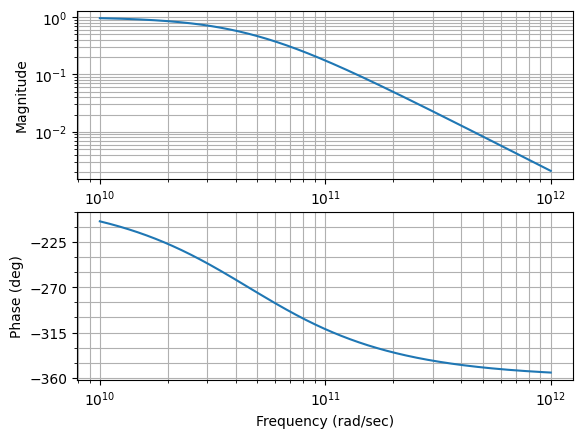

In [94]:
initial_capacitance_bode = os.path.join(plot_path, "initial_capacitance_bode.png")
ct.bode(tf) # Bode plot of the transfer function
plt.savefig(initial_capacitance_bode)
plt.show()

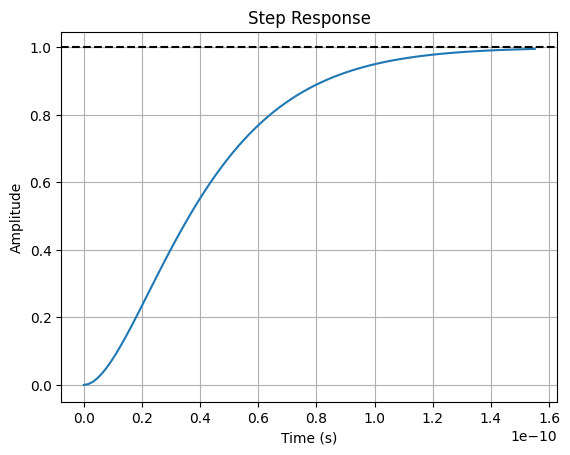

{'RiseTime': 7.049268019129987e-11,
 'SettlingTime': 1.2218731233158643e-10,
 'SettlingMin': -0.9999900000999992,
 'SettlingMax': -0.9019308928273833,
 'Overshoot': 0,
 'Undershoot': 0,
 'Peak': 0.995531918687238,
 'PeakTime': 1.550838964208597e-10,
 'SteadyStateValue': -0.9999900000999992}

In [95]:
# t = np.linspace(0, 1, 1000) # Time vector for the step response

t, y = ct.step_response(tf ) # Step response of the system
plt.plot(t, -y) # Plotting the step response
plt.title("Step Response")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.axhline(y=1, color='k', linestyle='--')
plt.show()
# show step response charactersistics
S = ct.step_info(tf)
S

## Cf_opt = 75.6 pF ##
Assuming the photdiode introduces a stray C of 1.1 e-3 pF.
This capacitor is about 1000 times smaller than the previous version. It is a consequence of trying to approach a bessel system and is a lower bound on capacitance. If we go lower, expect noise, ringing and general bad stuff.

In [96]:
optimized_capacitance_bode = os.path.join(plot_path, "optimized_capacitance_bode.png")
ct.bode(tf_opt) # Bode plot of the transfer function
plt.savefig(optimized_capacitance_bode)
plt.show()


t_opt, y_opt = ct.step_response(tf_opt ) # Step response of the system
plt.plot(t_opt, -y_opt) # Plotting the step response
plt.title("Step Response")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.axhline(y=1, color='k', linestyle='--')
plt.show()
#Frequency behavior quite good
S = ct.step_info(tf_opt)
S
#there is an ever so slight overshoot in the response here. almost 0.5%

LinAlgError: Array must not contain infs or NaNs

## Cf_opt = 105 pF ##
Assuming the photdiode introduces a stray C of 100 pF and the TIA a stray of 100 pF.

0.001277506210468914
Cf = 1.0469827549436106e-10 bessel condition True
Transfer function:  
         -3.069e+14
----------------------------
s^2 + 3.702e+07 s + 3.07e+14



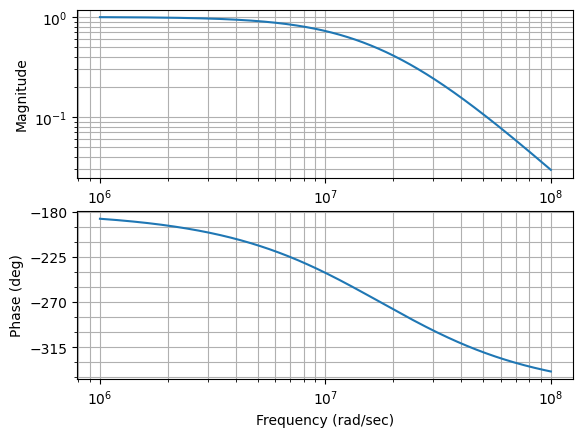

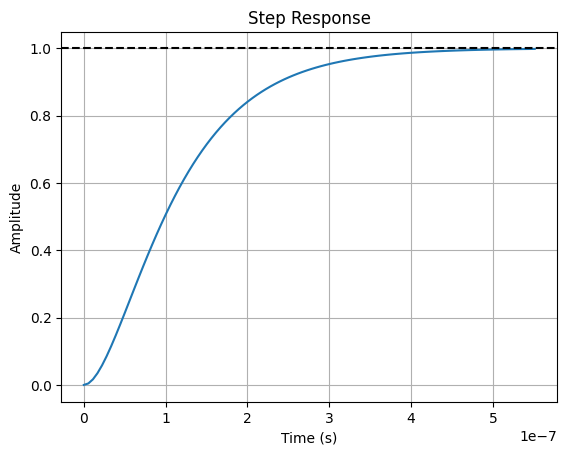

{'RiseTime': 2.0596203330723533e-07,
 'SettlingTime': 3.72958276529318e-07,
 'SettlingMin': -0.999990000099999,
 'SettlingMax': -0.9010143202095895,
 'Overshoot': 0,
 'Undershoot': 0,
 'Peak': 0.9979428050113113,
 'PeakTime': 5.510876026328729e-07,
 'SteadyStateValue': -0.999990000099999}

In [ ]:
Ci2 = 100*1e-12
roots2 = find_Cf(A0,omega0,Ci2,Rf)
Cf_opt2 = roots2[1]
print(f"Cf = {Cf_opt2} bessel condition",bessel_condition(Cf,A0,omega0,Ci2,Rf))

tf_opt2 = transferfunction(Cf_opt2,A0,omega0,Ci,Rf)
optimized_capacitance_bode_v2 = os.path.join(plot_path, "optimized_capacitance_bode_v2.png")
ct.bode(tf_opt2) # Bode plot of the transfer function
plt.savefig(optimized_capacitance_bode_v2)
plt.show()


t_opt2, y_opt2 = ct.step_response(tf_opt2 ) # Step response of the system
plt.plot(t_opt2, -y_opt2) # Plotting the step response
plt.title("Step Response")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid()
plt.axhline(y=1, color='k', linestyle='--')
plt.show()
#frequency behavior is not bad
S = ct.step_info(tf_opt2)
S

# SIMULATION #
Room for simulation
It is good to run this for a couple of options of Cf

In [ ]:
import sim_funcs as sf
# Define some typical geometry and values
f = 1366# w/m^2
b = 1e-2# baffle hole size
d = 5e-2 #cell size
h = 5e-3 #baffle eight


def moving_sun(t):
    # The sun is moving in circles on the sky
    b_t =  0.1 * np.cos(0.1* np.pi * t)*np.pi
    a_t = 0.1 * np.sin(0.1* np.pi * t)*np.pi
    return b_t*180/np.pi, a_t*180/np.pi

In [ ]:
# Model the system after current input
time = np.linspace(0,100,1000)
b_t, a_t = moving_sun(time)
# when someone figures out how to do boolian shenanigans on massive arrays,
# This can become so much faster
l_1, l_2, l_3, l_4, l_max = [],[],[],[],[]
for i,t in enumerate(time):
    l_1_i, l_2_i, l_3_i, l_4_i, l_max_i = sf.illumination(f, b, d, h, a_t[i], b_t[i])
    l_1.append(l_1_i)
    l_2.append(l_2_i)
    l_3.append(l_3_i)
    l_4.append(l_4_i)
    l_max.append(l_max_i)

l_1, l_2, l_3, l_4, l_max = np.array(l_1), np.array(l_2), np.array(l_3), np.array(l_4), np.array(l_max)
#calculate currents
I1, I2, I3, I4, = sf.power_to_current(l_1, l_2, l_3, l_4, l_max)

# The output data of the response is the property y of TimeResponseData
Q1, Q2, Q3, Q4 = (ct.forced_response(tf_opt, time, I1).y * Rf,
                  ct.forced_response(tf_opt, time, I2).y * Rf,
                  ct.forced_response(tf_opt, time, I3).y * Rf,
                  ct.forced_response(tf_opt, time, I4).y * Rf)
# Calculate angles using a 12 bit system and a ref voltage of 3.3
V1_frac, V2_frac, V3_frac, V4_frac = (sf.ADC_DAC(Q1, 12, 3.3), sf.ADC_DAC(Q2, 12, 3.3),
                                      sf.ADC_DAC(Q3, 12, 3.3), sf.ADC_DAC(Q4, 12, 3.3))
alpha, beta = sf.sun_angles(Q1=V1_frac,Q2=V2_frac,Q3=V3_frac,Q4=V4_frac)

c:\Programming\test\Space-Engineering-Practical\sim_funcs.py:101: RuntimeWarning: invalid value encountered in divide
  Sa = (Q1 + Q4 - Q2 - Q3)/Q_tot
c:\Programming\test\Space-Engineering-Practical\sim_funcs.py:102: RuntimeWarning: invalid value encountered in divide
  Sb = (Q1 + Q2 - Q3 - Q4)/Q_tot


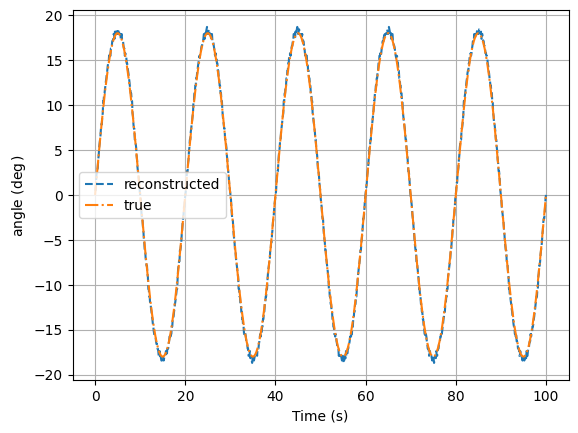

In [ ]:
plt.plot(time, alpha.reshape(-1,), linestyle="--", label = "reconstructed")
plt.plot(time, a_t, linestyle="-.",label = "true")
plt.legend()
plt.grid()
plt.xlabel("Time (s)")
plt.ylabel("angle ($\deg$)")
plt.show()

If you are here, I hope you read through most of the doc and partially understand it. The last part is quite important as it specifies our system performance. Consider doing some statistics with is.
Also note that the sunsensor geometry is not final. The system is also quite sensitive to sunsensor geometry variations as for some combinations of b,d,h, the system may be insensitive to large angles.
When using this, please consider that we need several scenarios for Cf.
